<div style=float:right><img src="assets/img/appliedai-logo.png" width=100 style="margin: 0px 20px"></img></div>


##### Jonathan Sedar Personal project
## PyMC3 vs PyStan Comparison
_Spring 2016_

This set of Notebooks and scripts comprise the **pymc3_vs_pystan** personal project by Jonathan Sedar of Applied AI Ltd, written primarily for presentation at the PyData London 2016 Conference.

The project demonstrates hierarchical linear regression using two Bayesian inference frameworks: PyMC3 and PyStan. The project borrows heavily from code written for Applied AI Ltd and is supplied here for educational purposes only. No copyright or license is extended to users.

    
# 10_DataEngineering

#### Acquisition, Basic Cleaning, Feature Creation
    
    
    
+ [Setup](#Setup)
    + [Local Functions](#Local-Functions)
    + [Load Raw Data](#Load-Raw-Data)


+ [Prepare Data](#Prepare-Data)
    + [Cleaning and Exclusions](#Cleaning-and-Exclusions)
    + [Feature Creation](#Feature-Creation)
    + [Check size of data of interest](#Check-size-of-data-of-interest)
    + [Save to store](#Save-to-store)


# Setup

In [1]:
## Interactive magics
%matplotlib inline
%qtconsole --colors=linux

In [2]:
# general packages
import string
import regex as re
import requests
import sqlite3
from zipfile import ZipFile
from io import BytesIO
from convenience_functions import *
from ipywidgets import interactive, fixed

# scientific packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid", palette="muted")
# plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 12, 6
np.random.seed(0)

## Local Functions

In [3]:
def get_cardata(sqlcnx, tblnm='raw'):
    """ Extract car data from local sqlite db or go download it 
        Deals with zipfiles nicely
    """

    zip_url = 'http://carfueldata.direct.gov.uk/additional/aug2015/'
    zip_fn = 'download-data-for-Aug-2015-Euro-6.zip'
    
    csr = cnxsql.cursor()
    tblexist = csr.execute(("select * from sqlite_master " +
                           "where type = 'table' and name = ?"), (tblnm,)).fetchall()
    
    if len(tblexist) == 0:  # go get info from interwebs
        try:         
            r = requests.get(zip_url + zip_fn)
            f = ZipFile(BytesIO(r.content), mode='r')
            fn = f.namelist()[0]
            dfraw = pd.read_csv(f.open(fn), encoding='cp1252', sep=',') # <- Excel encoding!   
            dfraw.rename(columns=lambda x: snakey_lowercase(x), inplace=True)
            dfraw.drop([c for c in dfraw.columns if c[:3] == 'unn'], inplace=True, axis=1)
            dfraw.to_sql('raw', cnxsql, if_exists='replace', index=None)
            print('Retrived dataset from web and stored in db')
        
        except Exception as e:
            raise e     # TODO make error better
    else:
        dfraw = pd.read_sql('select * from raw', cnxsql, index_col=None)
        print('Used dataset from existing db')
       
    return dfraw


def clean_transmission(x):
    """ extract info from transmission: manual / auto / semiauto """
    try:
        s = re.sub('^[0-9]{1}','', x.lower())
    except:
        return ''
       
    if (s[0] == 'a') | (s[:2] == 'qa'):
        return 'auto'
    
    elif s[:3] =='mul':
        return 'auto'
    
    elif (s[0] == 'm') | (s[:2] == 'qm'):
        if len(s) == 1:
            print(x)
        if s[1] != 'u':
            return 'manual'
        
    elif (s[0] == 'd') | (s[:2] == 'qd') | \
        (re.search('ssg$',s) != None) | (re.search('cvt$',s) != None) | \
        (re.search('sat[0-9]',s) != None):
        return 'semiauto'
    
    else:
        return 'unknown'
    

## Load Raw Data

In [4]:
cnxsql = sqlite3.connect('data/car_emissions.db')

In [5]:
dfraw = get_cardata(cnxsql)
custom_describe(dfraw)

Used dataset from existing db <sqlite3.Connection object at 0x115b89570>
(2666, 27)


,2607,1653,835,count,mean,std,min,25%,50%,75%,max,dtype
manufacturer,VOLVO,MERCEDES-BENZ,BMW,2666,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
model,"V40, MY16","C-Class Saloon, Model Year 2015",7 Series F01/F02,2666,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
description,T3,"C 200 with 18"" rear wheels",730d Saloon,2666,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
transmission,6AT,M6,A8,2657,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
engine_capacity,1498,1991,2993,2659,2072.17,902.38,395.0,1560.00,1984.0,1999.00,6752.0,float64
fuel_type,Petrol,Petrol,Diesel,2666,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
electric_energy_consumption_mileskwh,NaN,NaN,NaN,19,4.96,1.95,3.4,3.95,4.6,5.45,12.4,float64
whkm,NaN,NaN,NaN,19,135.21,31.38,50.0,114.00,135.0,156.50,182.0,float64
maximum_range_km,NaN,NaN,NaN,19,103.05,73.69,31.0,34.50,53.0,172.50,212.0,float64
maximum_range_miles,NaN,NaN,NaN,19,63.89,45.90,19.0,21.50,33.0,107.50,132.0,float64


---

# Prepare Data

## Cleaning and Exclusions

##### Rename cols

In [6]:
dfraw.rename(columns={'manufacturer':'mfr', 'description':'desc'
                     ,'transmission':'trans'}, inplace=True)

##### Select features of interest

In [56]:
ft_cat = ['mfr','model','desc','trans','fuel_type']
ft_num_shared = ['metric_combined', 'metric_extra_urban', 'metric_urban_cold'
                 ,'engine_capacity', 'emissions_co_mgkm', 'emissions_nox_mgkm']
ft_num_diesel = ['particulates_no_mgkm', 'thc_nox_emissions_mgkm']
ft_num_petrol = ['thc_emissions_mgkm']     

In [57]:
df = dfraw[ft_cat + ft_num_shared +  ft_num_diesel + ft_num_petrol].copy()
df.shape

(2666, 14)

##### Drop rows containing nulls in shared features

In [58]:
for ft in ft_cat + ft_num_shared:
    df = df.loc[~pd.isnull(df[ft])]
    print('{} {}'.format(ft, df.shape))

mfr (2666, 14)
model (2666, 14)
desc (2666, 14)
trans (2657, 14)
fuel_type (2657, 14)
metric_combined (2657, 14)
metric_extra_urban (2647, 14)
metric_urban_cold (2647, 14)
engine_capacity (2647, 14)
emissions_co_mgkm (2647, 14)
emissions_nox_mgkm (2647, 14)


##### Clean strings

In [59]:
for col in ['mfr','model','desc','fuel_type']:
    df[col] = df[col].apply(lambda x: x.lower())

##### Change dtypes and remove junk

In [60]:
# some cols contain numerics with comma decimals, European-style. Remove rows: can't trust.

colswcommadecimal = ['emissions_nox_mgkm','thc_nox_emissions_mgkm','particulates_no_mgkm']

for col in colswcommadecimal:
    df = df.loc[df[col].apply(lambda x: re.search('[0-9]\,[0-9]',str(x)) == None)]

print(df.shape)

(2646, 14)


In [61]:
# a couple of numeric cols still report as object type, coerce to numeric

for col in ['emissions_nox_mgkm', 'particulates_no_mgkm','thc_nox_emissions_mgkm']:
    df[col] = df[col].astype(np.float)

In [62]:
custom_describe(df)

(2646, 14)


,2379,705,2617,count,mean,std,min,25%,50%,75%,max,dtype
mfr,toyota,bmw,volvo,2646,NaN,NaN,abarth,NaN,NaN,NaN,volvo,object
model,"verso, my2015","4 series gran coupé f36, from june 2014","v60, my15",2646,NaN,NaN,1 seri,NaN,NaN,NaN,zafira,object
desc,icon 1.8 v-matic m-drive s,420d xdrive gran coupé - 17'' tyres,d4 r-design,2646,NaN,NaN,'1 air,NaN,NaN,NaN,zc 1.6,object
trans,MultiDriv,M6,8AT,2646,NaN,NaN,5MT,NaN,NaN,NaN,SAT6,object
fuel_type,petrol,diesel,diesel,2646,NaN,NaN,diesel,NaN,NaN,NaN,petrol,object
metric_combined,6.6,4.6,4.3,2646,5.65,1.87,3.1,4.4,5.1,6.30,16,float64
metric_extra_urban,5.4,4,3.9,2646,4.85,2.35,0,4.0,4.5,5.30,107,float64
metric_urban_cold,8.6,5.6,5.1,2646,7.10,3.00,0,5.2,6.2,8.10,24.7,float64
engine_capacity,1798,1995,1969,2646,2072.58,903.62,395,1560.0,1984.0,1999.00,6752,float64
emissions_co_mgkm,278,147,132,2646,268.34,140.71,30,162.0,243.0,341.75,913,float64


## Feature Creation

##### Derive transmission

manual      1280
auto        1033
semiauto     333
Name: trans_cln, dtype: int64
0


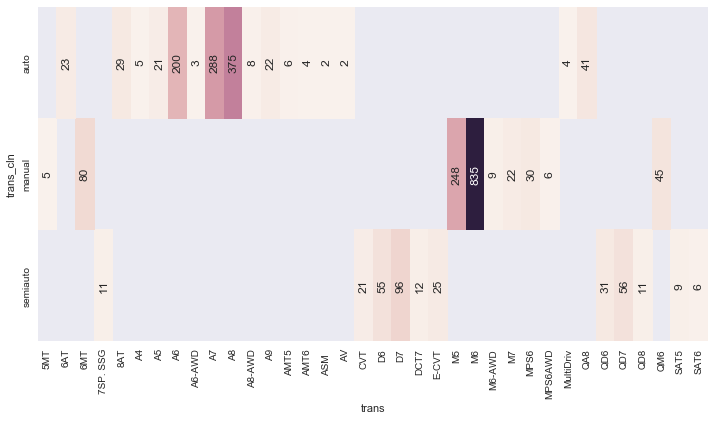

In [63]:
df['trans_cln'] = df['trans'].apply(lambda x: clean_transmission(x))
print(df['trans_cln'].value_counts())
print(df['trans'].value_counts().sum() - df['trans_cln'].value_counts().sum())
_ = sns.heatmap(df.groupby(['trans_cln','trans']).size().unstack()
                 ,cbar=False, annot=True, fmt='.0f',annot_kws={'rotation':'90'})

In [64]:
# seems good, overwrite transmission and remove transmission_cln
df.drop('trans', axis=1, inplace=True)
df.rename(columns={'trans_cln':'trans'}, inplace=True)

##### Derive TDi

In [65]:
def get_tdi(r):
    if r['fuel_type'] in set(['diesel', 'diesel electric']):
        if re.search('tdi',r['desc']) != None:
            return True
        else:
            return False
    else:
        return False

df['is_tdi'] = df.apply(lambda r: get_tdi(r), axis=1)
df['is_tdi'].sum()

299

In [66]:
# check against fuel type
df.groupby(['fuel_type','is_tdi']).size().unstack()

is_tdi,False,True
fuel_type,,
diesel,994.0,299.0
diesel electric,14.0,NaN
petrol,1304.0,NaN
petrol electric,10.0,NaN
petrol hybrid,25.0,NaN


##### Simplify fuel type

In [67]:
def simplify_fuel_type(r):
    if r['fuel_type'] in set(['petrol', 'diesel']):
        return r['fuel_type']
    else:
        return 'hybrid'

df['fuel_type'] = df.apply(lambda r: simplify_fuel_type(r), axis=1)
df.groupby(['fuel_type']).size()

fuel_type
diesel    1293
hybrid      49
petrol    1304
dtype: int64

##### Add hierarchical parent company ownership structure

In [68]:
parent = {
    'aston martin lagonda':['aston martin lagonda']
    ,'bmw':['bmw','mini','rolls royce']
    ,'daimler-ag':['mercedes-benz','smart']          
    ,'fiat':['fiat','abarth','alfa romeo','chrysler jeep','ferrari','lancia','maserati','ram']
    ,'ford':['ford']
    ,'gm':['buick','cadillac','chevrolet','vauxhall']
    ,'honda':['honda','acura']
    ,'hyundai':['hyundai','kia']
    ,'mazda':['mazda']
    ,'mclaren':['mclaren']
    ,'mitsubishi':['mitsubishi']
    ,'peugeot-citroen':['peugeot','citroen','ds']
    ,'renault-nissan':['renault','dacia','nissan']
    ,'saab':['saab']
    ,'shanghai-auto':['ssangyong']
    ,'subaru':['subaru']
    ,'suzuki':['suzuki']
    ,'tata':['jaguar','land rover']
    ,'toyota':['toyota','lexus']
    ,'volkswagen':['volkswagen','audi','bentley motors','lamborghini','porsche','seat','skoda']
    ,'geely':['volvo']
}

# and invert dictionary for reverse lookup
parent_inv = {}
for k, vs in parent.items():
    for v in vs:
        parent_inv[v] = k

In [69]:
df['parent'] = df['mfr'].apply(lambda x: parent_inv[x])
ft_cat.append('parent')

In [70]:
# check that every car has a parent
df.shape[0] == df.groupby(['mfr','parent']).size().sum()

True

##### Plot ownership structure

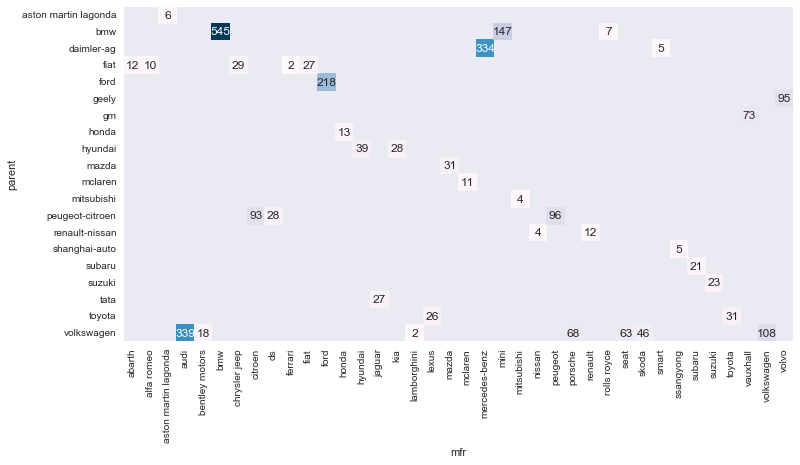

In [71]:
f, ax1d = plt.subplots(1,1,figsize=(12,6))
ax = sns.heatmap(df.groupby(['mfr','parent']).size().unstack(0)
                 ,cmap="PuBu", ax=ax1d, annot=True, fmt='.0f', cbar=False)

##### Add boolean for mfr == volkswagen, and parent == volkswagen

In [72]:
df['mfr_is_vw'] = df['mfr'] == 'volkswagen'
df['parent_is_vw'] = df['parent'] == 'volkswagen'

In [73]:
df.groupby(['mfr_is_vw','parent_is_vw']).size().unstack()

parent_is_vw,False,True
mfr_is_vw,,
False,2002.0,536.0
True,NaN,108.0


##### Final check

In [74]:
custom_describe(df)

(2646, 18)


,2151,2239,1711,count,mean,std,min,25%,50%,75%,max,dtype
mfr,porsche,seat,mercedes-benz,2646,NaN,NaN,abarth,NaN,NaN,NaN,volvo,object
model,cayenne,new ibiza st,"cla-coupé, model year 2015½",2646,NaN,NaN,1 seri,NaN,NaN,NaN,zafira,object
desc,diesel,1.0 95ps eco,cla 200 cdi with 18'' rear wheels,2646,NaN,NaN,'1 air,NaN,NaN,NaN,zc 1.6,object
fuel_type,diesel,petrol,diesel,2646,NaN,NaN,diesel,NaN,NaN,NaN,petrol,object
metric_combined,6.8,4.1,4,2646,5.65,1.87,3.1,4.4,5.1,6.30,16,float64
metric_extra_urban,6.2,3.6,3.6,2646,4.85,2.35,0,4.0,4.5,5.30,107,float64
metric_urban_cold,7.8,5,4.9,2646,7.10,3.00,0,5.2,6.2,8.10,24.7,float64
engine_capacity,2967,999,2143,2646,2072.58,903.62,395,1560.0,1984.0,1999.00,6752,float64
emissions_co_mgkm,88,211,158,2646,268.34,140.71,30,162.0,243.0,341.75,913,float64
emissions_nox_mgkm,46,21,65,2646,37.38,18.63,1,23.0,35.0,52.00,158,float64


##### And write to db

In [75]:
df.reset_index(inplace=True)
del df['index']
df.to_sql('cars', cnxsql, if_exists='replace', index=None)
cnxsql.close()

## Quickly check size of data of interest: Volkswagen

##### Manufacturer

VW Cars are 108 / 2646 = 4.1%


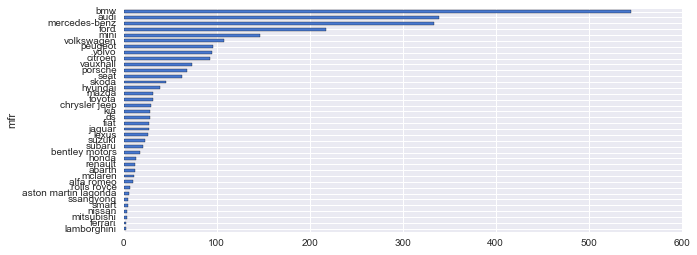

In [77]:
grp = df.groupby('mfr').size().sort_values()#[::-1]
ax = grp.plot(kind='barh', figsize=(10,4))
print('VW Cars are {} / {} = {:.1%}'.format(grp['volkswagen'], grp.sum()
                                       ,grp['volkswagen'] / grp.sum()))

VW Group are 644 / 2646 = 24.3%


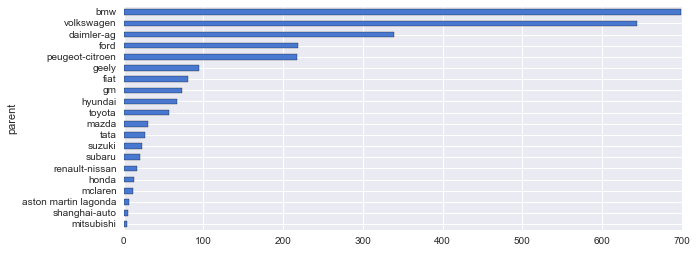

In [78]:
grp = df.groupby('parent').size().sort_values()#[::-1]
ax = grp.plot(kind='barh', figsize=(10,4))
print('VW Group are {} / {} = {:.1%}'.format(grp['volkswagen'], grp.sum()
                                       ,grp['volkswagen'] / grp.sum()))

**Observe**: 

+ There's a long tail of underrepresented cars, we might need to account for this later
+ Volkswagen is reasonably well represented in the full set with 4% of the total

---
**Applied AI Ltd &copy; 2016**  
<a href='http://www.applied.ai'>applied.ai</a>